# Analysis of the difference on the three types of activities fot the three kind of movements

# Load of the conectivity matrix

In [414]:
import numpy as np
import iberoSignalPro.preprocesa as ib
import mne
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import seaborn as sns
import networkx as nx

# My Tools libraies
from ntwktools import *
from statstools import * 

In [415]:
Carga_10 = np.load('3Carga_10p01.npy', allow_pickle=True)
Carga_5 = np.load('3Carga_5p01.npy',  allow_pickle=True)
Carga_0 = np.load('3Carga_0p01.npy',  allow_pickle=True)

Carga_5 = Carga_5[:-2]
Carga_0 = Carga_0[:-2]


Carga_10.shape, Carga_5.shape, Carga_0.shape


((41,), (41,), (41,))

In [416]:
ch_names = np.array(['HRV', 'RRV', 'EnvAnta', 'EnvAgo', 'Posicion', 'FC3', 'FCz', 'FC4',
       'CP3', 'C3', 'C1', 'Cz', 'C2', 'C4', 'CP4', 'P3', 'Pz', 'P4', 'O1',
       'Oz', 'O2'], dtype=object)

In [417]:
y, x, ro, deg, _ =ib.eloc_reader('../codigo/eloc16_bueno.txt')


new_x = np.array([x.min() - 0.021,     x.min() - 0.1,    x.max() + 0.1,  x.max() + 0.02, 0])
new_y = np.array([y.max() + 0.25,   y.max() + 0.25,     y.max() + 0.25, y.max() + 0.25, y.max() + 0.25])

x = np.concatenate((new_x, x))
y = np.concatenate((new_y, y))

## Band selection

mu ($\mu$), beta ($\beta$), gamma($\gamma$)

In [418]:
# ************************
# ************************
band = "gamma"
test_mat = Carga_10[0].get_network(band, band).matriz_act


# Metrics adquisition

* Input Node Degree: Measures the number of incoming connections to a node, indicating the extent to which a node (or brain region) is influenced by others.
* Output Node Degree: Represents the number of outgoing connections from a node, reflecting how much influence the node exerts on other nodes in the network.
* Betweenness Centrality: Quantifies the importance of a node as a bridge in the shortest paths between other nodes, highlighting its role in facilitating communication within the network.
* Clustering Coefficient: Evaluates the tendency of a node’s neighbors to form connections among themselves, providing insight into the local cohesiveness of the network.

In [419]:
ch_names = np.array(['HRV', 'RRV', 'EnvAnta', 'EnvAgo', 'Posicion', 'FC3', 'FCz', 'FC4',
       'CP3', 'C3', 'C1', 'Cz', 'C2', 'C4', 'CP4', 'P3', 'Pz', 'P4', 'O1',
       'Oz', 'O2'], dtype=object)

In [420]:
def get_ntwk_metrics(Cargas, band = "mu", tipo = "actividad", thresh = 0, only_eeg  = True, ch_names = None, same_windows = True):
    if ch_names is None:
        ch_names = np.array(['FC3', 'FCz', 'FC4', 'CP3', 'C3', 'C1', 'Cz', 'C2', 'C4', 'CP4', 'P3', 'Pz', 'P4', 'O1', 'Oz', 'O2'], dtype=object)
    in_degree_centrality_all = []
    out_degree_centrality_all = []
    betweenness_centrality_all = []
    max_win = []

    for i, carga_ in enumerate(Cargas):
        carga = Cargas[i]
        if same_windows:
            len_windows_act = carga.get_network(band, band).array_mat_act.shape[0]
            len_windows_rep = carga.get_network(band, band).array_mat_rep.shape[0]
            len_windows = min(len_windows_act, len_windows_rep)


        if tipo == "actividad":
            if same_windows:
                matrices_actividad = carga.get_network(band, band).array_mat_act[:len_windows]
            else:
                matrices_actividad = carga.get_network(band, band).array_mat_act
            
            in_degree_centrality_all_temp = []
            out_degree_centrality_all_temp = []
            betweenness_centrality_all_temp = []

            for test_mat in matrices_actividad:
                if only_eeg:
                    test_mat = test_mat[5:, 5:]

                
                in_degree_centrality, out_degree_centrality = get_deg(test_mat)
                in_degree_centrality_all_temp.append(in_degree_centrality)
                out_degree_centrality_all_temp.append(out_degree_centrality)

                bet = betweenness_centrality(test_mat)

                betweenness_centrality_all_temp.append(bet)

        else:
            if same_windows:
                matrices_reposo = carga.get_network(band, band).array_mat_rep[:len_windows]
            else:
                matrices_reposo = carga.get_network(band, band).array_mat_rep
            
            in_degree_centrality_all_temp = []
            out_degree_centrality_all_temp = []
            betweenness_centrality_all_temp = []
            
            for test_mat in matrices_reposo:
                test_mat = test_mat
                if only_eeg:
                    test_mat = test_mat[5:, 5:]

                
                in_degree_centrality, out_degree_centrality = get_deg(test_mat)
                in_degree_centrality_all_temp.append(in_degree_centrality)
                out_degree_centrality_all_temp.append(out_degree_centrality)
                
                bet = betweenness_centrality(test_mat)
                
                betweenness_centrality_all_temp.append(bet)
                
        
        in_degree_centrality_all_temp = np.array(in_degree_centrality_all_temp)
        out_degree_centrality_all_temp = np.array(out_degree_centrality_all_temp)
        betweenness_centrality_all_temp = np.array(betweenness_centrality_all_temp)
        
        
        in_degree_centrality_all_temp_padded = np.zeros((6, in_degree_centrality_all_temp.shape[1]))
        in_degree_centrality_all_temp_padded[:in_degree_centrality_all_temp.shape[0], :] = in_degree_centrality_all_temp
        
        out_degree_centrality_all_temp_padded = np.zeros((6, out_degree_centrality_all_temp.shape[1]))
        out_degree_centrality_all_temp_padded[:out_degree_centrality_all_temp.shape[0], :] = out_degree_centrality_all_temp
        
        betweenness_centrality_all_temp_padded = np.zeros((6, betweenness_centrality_all_temp.shape[1]))
        betweenness_centrality_all_temp_padded[:betweenness_centrality_all_temp.shape[0], :] = betweenness_centrality_all_temp
        max_win.append(in_degree_centrality_all_temp.shape[0])

        in_degree_centrality_all.append(in_degree_centrality_all_temp_padded)
        out_degree_centrality_all.append(out_degree_centrality_all_temp_padded)
        betweenness_centrality_all.append(betweenness_centrality_all_temp_padded)


    max_win = np.array(max_win)
    in_degree_centrality_all = np.array(in_degree_centrality_all)
    out_degree_centrality_all = np.array(out_degree_centrality_all)
    betweenness_centrality_all = np.array(betweenness_centrality_all)

    return in_degree_centrality_all, out_degree_centrality_all, max_win, betweenness_centrality_all

In [421]:
def promediar_ventanas(arr_act_10in, n_ventanas):
    suma_ventanas = np.sum(arr_act_10in, axis=1)
    promedio_ventanas = suma_ventanas / n_ventanas[:, np.newaxis]
    return promedio_ventanas

def desenvolver_ventanas(arr, n_ventanas, axis = 1):
    # Obtener las dimensiones originales
    num_sujetos, num_ventanas, num_canales = arr.shape
    num_ventanas = np.sum(n_ventanas)
    
    arr_desenvuelto = []
    for i in range(num_sujetos):
        for j in range(n_ventanas[i]):
            arr_desenvuelto.append(arr[i, j, :])
    arr_desenvuelto = np.array(arr_desenvuelto)

    if axis ==2:
    
        arr_desenvuelto = []
        for i in range(num_sujetos):
            for j in range(n_ventanas[i]):
                arr_desenvuelto.append(arr[i, j, :])
        arr_desenvuelto = np.array(arr_desenvuelto)
    
    return arr_desenvuelto

In [422]:
thresh = 0

arr_act_10in, arr_act_10out, act_n_ventanas_10, act_betweenness_centrality_10 = get_ntwk_metrics(Carga_10, band = band, tipo = "actividad", thresh=thresh, only_eeg=True, ch_names=ch_names[5:])
arr_act_10in = promediar_ventanas(arr_act_10in, act_n_ventanas_10)
arr_act_10out = promediar_ventanas(arr_act_10out, act_n_ventanas_10)
arr_betweenness_centrality_10 =promediar_ventanas(act_betweenness_centrality_10, act_n_ventanas_10)

arr_act_5in, arr_act_5out, act_n_ventanas_5, act_betweenness_centrality_5 = get_ntwk_metrics(Carga_5, band = band, tipo = "actividad",  thresh=thresh, only_eeg=True, ch_names=ch_names[5:])
arr_act_5in = promediar_ventanas(arr_act_5in, act_n_ventanas_5)
arr_act_5out = promediar_ventanas(arr_act_5out, act_n_ventanas_5)

arr_act_0in, arr_act_0out, act_n_ventanas_0, act_betweenness_centrality_0 = get_ntwk_metrics(Carga_0, band =band, tipo = "actividad",  thresh=thresh, only_eeg=True, ch_names=ch_names[5:])
arr_act_0in = promediar_ventanas(arr_act_0in, act_n_ventanas_0)
arr_act_0out = promediar_ventanas(arr_act_0out, act_n_ventanas_0)




In [423]:
thresh = 0

arr_act_10in, arr_act_10out, act_n_ventanas_10, act_betweenness_centrality_10 = get_ntwk_metrics(Carga_10, band = band, tipo = "actividad", thresh=thresh, only_eeg=True)
arr_act_10in = desenvolver_ventanas(arr_act_10in, act_n_ventanas_10)
arr_act_10out = desenvolver_ventanas(arr_act_10out, act_n_ventanas_10)
act_betweenness_centrality_10 = desenvolver_ventanas(act_betweenness_centrality_10, act_n_ventanas_10)

arr_rep_10in, arr_rep_10out, rep_n_ventanas_10, rep_betweenness_centrality_10 = get_ntwk_metrics(Carga_10, band = band, tipo = "reposo",  thresh=thresh, only_eeg=True)
arr_rep_10in = desenvolver_ventanas(arr_rep_10in, rep_n_ventanas_10)
arr_rep_10out = desenvolver_ventanas(arr_rep_10out, rep_n_ventanas_10)
rep_betweenness_centrality_10 = desenvolver_ventanas(rep_betweenness_centrality_10, rep_n_ventanas_10)

arr_act_5in, arr_act_5out, act_n_ventanas_5, act_betweenness_centrality_5 = get_ntwk_metrics(Carga_5, band = band, tipo = "actividad",  thresh=thresh, only_eeg=True)
arr_act_5in = desenvolver_ventanas(arr_act_5in, act_n_ventanas_5)
arr_act_5out = desenvolver_ventanas(arr_act_5out, act_n_ventanas_5)
act_betweenness_centrality_5 = desenvolver_ventanas(act_betweenness_centrality_5, act_n_ventanas_5)

arr_rep_5in, arr_rep_5out, rep_n_ventanas_5, rep_betweenness_centrality_5 = get_ntwk_metrics(Carga_5, band =band, tipo = "reposo",  thresh=thresh, only_eeg=True)
arr_rep_5in = desenvolver_ventanas(arr_rep_5in, rep_n_ventanas_5)
arr_rep_5out = desenvolver_ventanas(arr_rep_5out, rep_n_ventanas_5)
rep_betweenness_centrality_5 = desenvolver_ventanas(rep_betweenness_centrality_5, act_n_ventanas_5)

arr_act_0in, arr_act_0out, act_n_ventanas_0, act_betweenness_centrality_0 = get_ntwk_metrics(Carga_0, band =band, tipo = "actividad",  thresh=thresh, only_eeg=True)
arr_act_0in = desenvolver_ventanas(arr_act_0in, act_n_ventanas_0)
arr_act_0out = desenvolver_ventanas(arr_act_0out, act_n_ventanas_0)
act_betweenness_centrality_0 = desenvolver_ventanas(act_betweenness_centrality_0, act_n_ventanas_0)

arr_rep_0in, arr_rep_0out, rep_n_ventanas_0, rep_betweenness_centrality_0 = get_ntwk_metrics(Carga_0, band =band, tipo = "reposo",  thresh=thresh, only_eeg=True)
arr_rep_0in = desenvolver_ventanas(arr_rep_0in, rep_n_ventanas_0)
arr_rep_0out = desenvolver_ventanas(arr_rep_0out, rep_n_ventanas_0)
rep_betweenness_centrality_0 = desenvolver_ventanas(rep_betweenness_centrality_0, rep_n_ventanas_0)


In [424]:

def generate_big_df(Carga, band, ch_names, activtylabel="actividad", restlabel="reposo"):
    arr_actin, arr_actout, act_n_ventanas, be = get_ntwk_metrics(Carga, band=band, tipo="actividad")
    arr_actin = desenvolver_ventanas(arr_actin, act_n_ventanas)
    arr_actout = desenvolver_ventanas(arr_actout, act_n_ventanas)

    act_betweenness_centrality = desenvolver_ventanas(be, act_n_ventanas)
    
    
    #arr_repin, arr_repout, rep_n_ventanas, be = get_ntwk_metrics(Carga, band=band, tipo="reposo")
    #arr_repin = desenvolver_ventanas(arr_repin, rep_n_ventanas)
    #arr_repout = desenvolver_ventanas(arr_repout, rep_n_ventanas)

    #rep_betweenness_centrality = desenvolver_ventanas(be, rep_n_ventanas)
    
    column_names_in = ch_names + ["_input_degree"]
    label = [activtylabel] * arr_actin.shape[0] #+ [restlabel] * arr_repin.shape[0]

    df_in = pd.DataFrame(arr_actin, columns=column_names_in)
    df_in["label"] = label

    column_names_out = ch_names + ["_output_degree"]
    df_out = pd.DataFrame(arr_actout, columns=column_names_out)
    df_out["label"] = label


    column_names_bet = ch_names + ["_betweenness"]
    df_bet = pd.DataFrame(act_betweenness_centrality, columns=column_names_bet)
    df_bet["label"] = label

    big_df = pd.concat([df_in, df_out], axis=1)

    return df_in, df_out, df_bet


In [425]:
df10in, df10out, df10bet = generate_big_df(Carga_10, band, activtylabel="SE10 Activity", ch_names=ch_names[5:])
df5in, df5out, df5bet = generate_big_df(Carga_5, band, activtylabel="SE5 Activity", ch_names=ch_names[5:])
df0in, df0out, df0bet = generate_big_df(Carga_0, band, activtylabel="AM Activity", ch_names=ch_names[5:])

big_in = pd.concat([df10in, df5in, df0in])
big_out = pd.concat([df10out, df5out, df0out])
big_bet = pd.concat([df10bet, df5bet, df0bet])

In [426]:
def get_significat_cols(df_analisis, p_val = 0.01, label = "label", test = "paired_t_test", verbose = False):
    significat_cols = []
    p_values = []
    for col in df_analisis.columns:
        if col == "label":
            continue
        if test == "paired_t_test":
            T_stat, p_value = compute_paired_t_test(df_analisis, "label", col)
        elif test == "t_test":
            T_stat, p_value = compute_t_test(df_analisis, "label", col)
        elif test == "kruskal_wallis":
            T_stat, p_value = compute_kruskal_wallis_anova(df_analisis, "label", col)
        elif test == "one_way_anova":
            T_stat, p_value = compute_one_way_anova(df_analisis, "label", col)
        if p_value < p_val:
            if verbose:
                print(f" {col} - {p_value}")
            p_values.append(p_value)
            significat_cols.append(col)
    return significat_cols, p_values

# Statisticall tests

for adquisition of significant conection on diferent channels.



In [427]:
pval = 0.05

significant_columns_input, p_values = get_significat_cols(big_in, test = "one_way_anova", verbose=False, p_val=pval)
significant_columns_output, p_values = get_significat_cols(big_out, test = "one_way_anova", verbose=False, p_val=pval)
significant_columns_bet, p_values = get_significat_cols(big_bet, test = "one_way_anova", verbose=False, p_val=pval)

df_sig_inputs = big_in[significant_columns_input + ["label"]]
df_sig_inputs.columns = [col.split('_')[0] if col != 'label' else col for col in df_sig_inputs.columns]

df_sig_outputs = big_out[significant_columns_output + ["label"]]
df_sig_outputs.columns = [col.split('_')[0] if col != 'label' else col for col in df_sig_outputs.columns]

df_sig_bet = big_bet[significant_columns_bet + ["label"]]
df_sig_bet.columns = [col.split('_')[0] if col != 'label' else col for col in df_sig_bet.columns]


significant_inputs_channels = df_sig_inputs.columns[:-1]
significant_outputs_channels = df_sig_outputs.columns[:-1]
significant_bet_channels = df_sig_bet.columns[:-1]



In [428]:
print(f"Significant inputs: {significant_inputs_channels}")
print(f"Significant outputs: {significant_outputs_channels}")
print(f"Significant bet: {significant_bet_channels}")

Significant inputs: Index(['CP3', 'Oz'], dtype='object')
Significant outputs: Index(['C4', 'Pz'], dtype='object')
Significant bet: Index(['P3', 'Oz'], dtype='object')


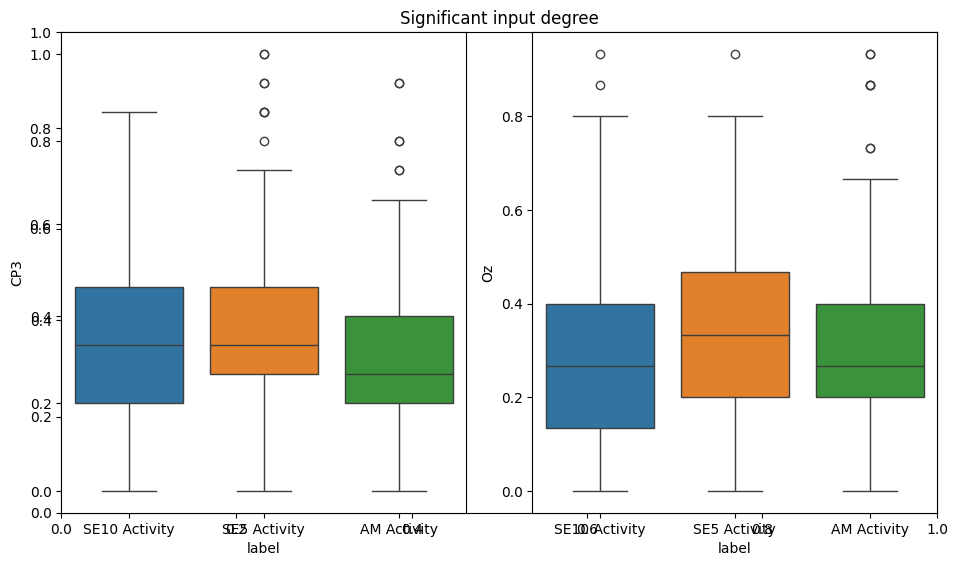

In [450]:

plt.figure(figsize=(10, 6))
plt.title("Significant input degree")
for i, col in enumerate(significant_inputs_channels):
    plt.subplot(1, len(significant_inputs_channels), i + 1)
    sns.boxplot(x="label", y=col, data=df_sig_inputs, hue="label")
    

plt.tight_layout()
plt.show()

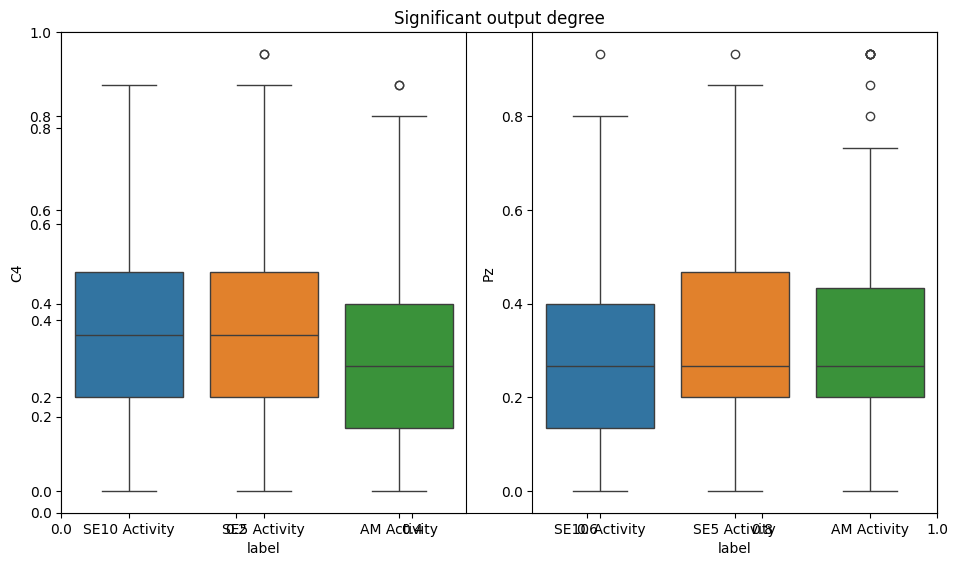

In [451]:


plt.figure(figsize=(10, 6))
plt.title("Significant output degree")
for i, col in enumerate(significant_outputs_channels):
    plt.subplot(1, len(significant_outputs_channels), i + 1)
    sns.boxplot(x="label", y=col, data=df_sig_outputs, hue="label")
    

plt.tight_layout()
plt.show()

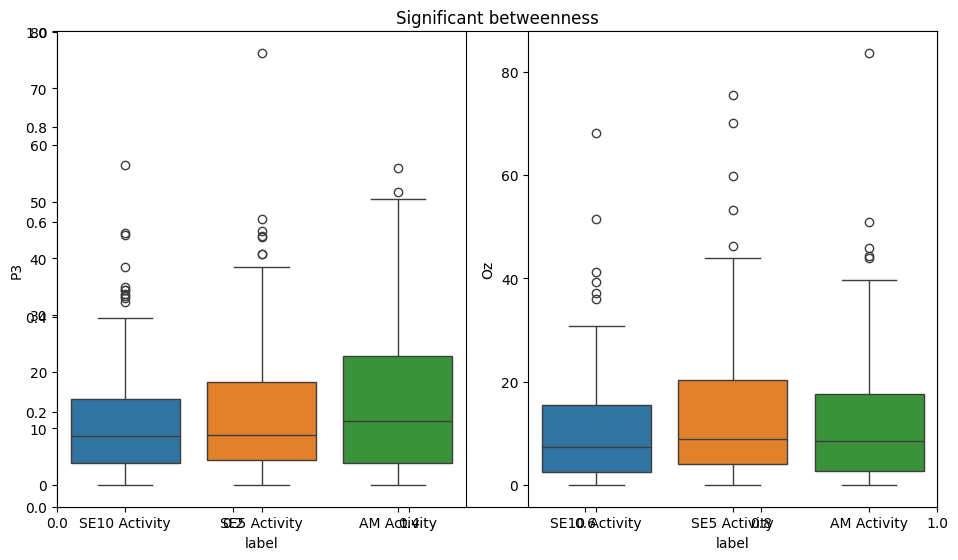

In [452]:

plt.figure(figsize=(10, 6))
plt.title("Significant betweenness")
for i, col in enumerate(significant_bet_channels):
    plt.subplot(1, len(significant_bet_channels), i + 1)
    sns.boxplot(x="label", y=col, data=df_sig_bet, hue="label")
    

plt.tight_layout()
plt.show()

In [432]:
def get_clusteringcoeff(adj_matrix):
    """
    Calculate the clustering coefficient for each node in the adjacency matrix.

    Parameters:
    adj_matrix (numpy.ndarray): Adjacency matrix representing the graph.

    Returns:
    numpy.ndarray: Array of clustering coefficients for each node.
    """
    # Create a graph from the adjacency matrix
    G = nx.from_numpy_array(adj_matrix)
    
    # Calculate the clustering coefficient for each node
    clustering_coeffs = nx.clustering(G)
    
    # Convert the clustering coefficients to a numpy array
    clustering_coeffs_array = np.array(list(clustering_coeffs.values()))
    
    return clustering_coeffs_array

In [433]:

def get_ntwk_clusteringcoeff(Cargas, band="mu", tipo="actividad", thresh=0, only_eeg=True, ch_names=None, same_windows=True):
    if ch_names is None:
        ch_names = np.array(['FC3', 'FCz', 'FC4', 'CP3', 'C3', 'C1', 'Cz', 'C2', 'C4', 'CP4', 'P3', 'Pz', 'P4', 'O1', 'Oz', 'O2'], dtype=object)
    
    clustering_coefficient_node_all = []
    max_win = []

    for carga in Cargas:
        if same_windows:
            len_windows_act = carga.get_network(band, band).array_mat_act.shape[0]
            len_windows_rep = carga.get_network(band, band).array_mat_rep.shape[0]
            len_windows = min(len_windows_act, len_windows_rep)

        if tipo == "actividad":
            if same_windows:
                matrices_actividad = carga.get_network(band, band).array_mat_act[:len_windows]
            else:
                matrices_actividad = carga.get_network(band, band).array_mat_act
            
            clustering_coefficient_node_all_each = []

            for test_mat in matrices_actividad:
                if only_eeg:
                    test_mat = test_mat[5:, 5:]

                temp_clustering = get_clusteringcoeff(test_mat)
                clustering_coefficient_node_all_each.append(temp_clustering)
         
        else:
            if same_windows:
                matrices_reposo = carga.get_network(band, band).array_mat_rep[:len_windows]
            else:
                matrices_reposo = carga.get_network(band, band).array_mat_rep
            
            clustering_coefficient_node_all_each = []

            for test_mat in matrices_reposo:
                if only_eeg:
                    test_mat = test_mat[5:, 5:]

                temp_clustering = get_clusteringcoeff(test_mat)
                clustering_coefficient_node_all_each.append(temp_clustering)
        
        clustering_coefficient_node_all_each = np.array(clustering_coefficient_node_all_each)
        max_win.append(clustering_coefficient_node_all_each.shape[0])
        if clustering_coefficient_node_all_each.shape[0] > 0:
            clustering_coefficient_node_all_temp_padded = np.zeros((6, clustering_coefficient_node_all_each.shape[1]))
            clustering_coefficient_node_all_temp_padded[:clustering_coefficient_node_all_each.shape[0], :] = clustering_coefficient_node_all_each
            clustering_coefficient_node_all.append(clustering_coefficient_node_all_temp_padded)
    
        
    clustering_coefficient_node_all = np.array(clustering_coefficient_node_all)
    max_win = np.array(max_win)

    return clustering_coefficient_node_all, max_win

In [434]:
arr_act_10cc, max_win = get_ntwk_clusteringcoeff(Carga_10, band = band, tipo = "actividad", thresh=thresh, only_eeg=True, ch_names=ch_names[5:])
act_10CC = np.mean(desenvolver_ventanas(arr_act_10cc, max_win), axis=0)

arr_rep_10cc, max_win = get_ntwk_clusteringcoeff(Carga_10, band = band, tipo = "reposo", thresh=thresh, only_eeg=True, ch_names=ch_names[5:])
rep_10CC = np.mean(desenvolver_ventanas(arr_rep_10cc, max_win), axis=0)

arr_act_5cc, max_win = get_ntwk_clusteringcoeff(Carga_5, band = band, tipo = "actividad", thresh=thresh, only_eeg=True, ch_names=ch_names[5:])
act_5CC = np.mean(desenvolver_ventanas(arr_act_5cc, max_win), axis=0)

arr_rep_5cc, max_win = get_ntwk_clusteringcoeff(Carga_5, band = band, tipo = "reposo", thresh=thresh, only_eeg=True, ch_names=ch_names[5:])
rep_5CC = np.mean(desenvolver_ventanas(arr_rep_5cc, max_win), axis=0)

arr_act_0cc, max_win = get_ntwk_clusteringcoeff(Carga_0, band = band, tipo = "actividad", thresh=thresh, only_eeg=True, ch_names=ch_names[5:])
act_0CC = np.mean(desenvolver_ventanas(arr_act_0cc, max_win), axis=0)

arr_rep_0cc, max_win = get_ntwk_clusteringcoeff(Carga_0, band = band, tipo = "reposo", thresh=thresh, only_eeg=True, ch_names=ch_names[5:])
rep_0CC = np.mean(desenvolver_ventanas(arr_rep_0cc, max_win), axis=0)


In [435]:
def generate_df(Carga, banda, label_act = "actividad", label_rep = "reposo", ch_names = ch_names[5:]):
    arr_act_10cc, max_win = get_ntwk_clusteringcoeff(Carga, band = band, tipo = "actividad", thresh=thresh, only_eeg=True, ch_names=ch_names[5:])
    act_10CC = desenvolver_ventanas(arr_act_10cc, max_win)

    #arr_rep_10cc, max_win = get_ntwk_clusteringcoeff(Carga, band = band, tipo = "reposo", thresh=thresh, only_eeg=True, ch_names=ch_names[5:])
    #rep_10CC = desenvolver_ventanas(arr_rep_10cc, max_win)

    act_label = label_act
    rep_label = label_rep

    df_act = pd.DataFrame(act_10CC, columns=ch_names)
    df_act["label"] = act_label

    #df_rep = pd.DataFrame(rep_10CC, columns=ch_names)
    #df_rep["label"] = rep_label

    #df = pd.concat([df_act, df_rep], axis=0)

    return df_act



In [436]:
df_10 = generate_df(Carga_10, band, label_act="SE10 Activity")
df_5 = generate_df(Carga_5, band, label_act="SE5 Activity")
df_0 = generate_df(Carga_0, band, label_act="AM Activity")

big_cc = pd.concat([df_10, df_5, df_0])

In [437]:
big_cc.head()

,FC3,FCz,FC4,CP3,C3,C1,Cz,C2,C4,CP4,P3,Pz,P4,O1,Oz,O2,label
0,0.285714,0.333333,0.200000,0.333333,0.000000,0.266667,0.666667,0.000000,0.200000,0.200000,0.300000,0.200000,0.200000,0.333333,0.000000,0.166667,SE10 Activity
1,0.000000,0.400000,0.000000,0.333333,0.000000,1.000000,0.700000,0.000000,0.428571,0.236364,0.300000,0.000000,0.000000,0.666667,0.666667,1.000000,SE10 Activity
2,0.535714,0.466667,0.600000,0.527778,0.321429,0.523810,0.428571,0.266667,0.500000,0.511111,0.400000,0.733333,0.600000,0.476190,1.000000,0.000000,SE10 Activity
3,0.700000,0.846154,0.863636,0.954545,0.954545,0.769231,0.963636,0.954545,0.800000,0.769231,0.954545,1.000000,0.730769,0.954545,0.836364,0.863636,SE10 Activity
4,0.618182,0.604396,0.727273,0.727273,0.892857,0.500000,0.892857,0.777778,0.900000,0.666667,0.727273,0.653846,0.688889,0.763636,1.000000,0.722222,SE10 Activity


In [438]:
p_val = 0.05

significant_columns_cc, p_values = get_significat_cols(big_cc, test = "one_way_anova", verbose=False, p_val=pval)

df_cc_sig = big_cc[significant_columns_cc + ["label"]]
df_cc_sig.columns = [col.split('_')[0] if col != 'label' else col for col in df_cc_sig.columns]


significant_cc_channels = df_cc_sig.columns[:-1]


In [439]:
print (f"Significant clustering coefficient channels: {significant_cc_channels}")

Significant clustering coefficient channels: Index(['P4'], dtype='object')


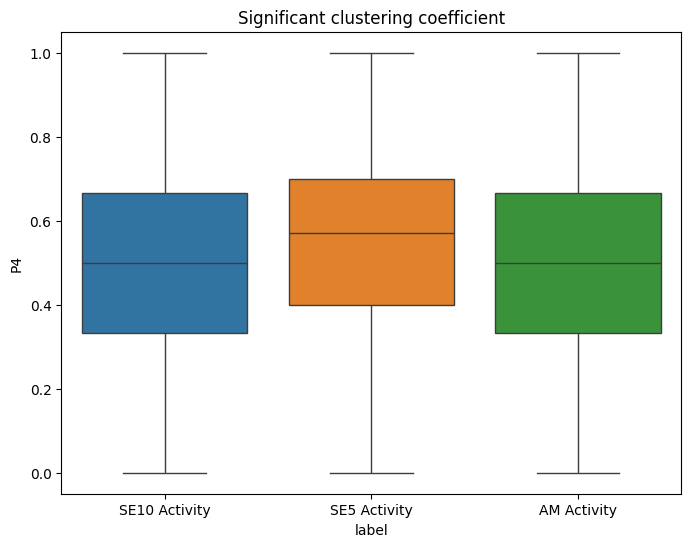

In [440]:
plt.figure(figsize=(8, 6))
plt.title("Significant clustering coefficient")
for i, col in enumerate(significant_cc_channels):
    plt.subplot(1, len(significant_cc_channels), i + 1)
    sns.boxplot(x="label", y=col, data=df_cc_sig, hue="label")
    